In [1]:
import os
import csv
import numpy as np
import math
import pickle
from scipy.spatial.distance import cdist
from scipy.stats import mode, kurtosis, skew
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu, points_in_poly
from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.filters import threshold_yen, gaussian, unsharp_mask
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sn
%matplotlib inline

In [2]:
# Display Function to display images
def display(img, img_title):
    '''
    img:        image matrix to display
    img_title:  Title to display on image matrix plot
    '''
    io.imshow(img)
    plt.title("{}".format(img_title))
    io.show()

In [3]:
# Display Function to show predictions on bounding box
def displayprediction(imgs, path, locs, ypred, comp, labs, mode=''):
    '''
    imgs:   list of all image file names
    path:   path where image files are located
    locs:   roi [minr, minc, maxr, maxc], for all image components obtained during feature extraction
    ypred:  predicted output value for each component
    labs:   unique class and labels 
            {0: 'a', 1: 'd', 2: 'f', 3: 'h', 4: 'k', 5: 'm', 6: 'n', 7: 'o', 
            8: 'p', 8: 'q', 10: 'r', 11: 's', 12: 'u', 13: 'w', 14: 'x', 15: 'z'}
    mode:   train image prediction output is class value (0,1...,15)
            test image prediction output is lables (a,d,...,z)
            if mode = 'Train', take class value as key and print its value from labs dictionary
            if mode != 'Train', directly print predicted labels
    '''
    
    i = -1
    k = -1
    for im in sorted(imgs):
        in_img = path + '/' + im
        img_label, img_binary = processImage(in_img, 'Predict')
        io.imshow(img_binary)
        ax = plt.gca()

        i += 1
        for j in range(comp[i]):
            k += 1
            ax.add_patch(Rectangle((locs[k][1], locs[k][0]), locs[k][3] - locs[k][1], locs[k][2] - locs[k][0], fill = False, edgecolor = 'red', linewidth = 1))
            if mode == 'Train':
                ax.text(locs[k][3]+1, locs[k][0], '{}'.format(labs.get(ypred[k])), fontsize=10, weight='bold', color='g')
            else:
                ax.text(locs[k][3]+1, locs[k][0], '{}'.format(ypred[k]), fontsize=10, weight='bold', color='g')
        
        ax.set_title('Predictions')
        io.show()

In [4]:
# Function to process image for feature extraction
def processImage(in_img, mode = '', disp = False):
    '''
    in_img: single image file path
    mode:   if mode = 'Predict' [during printing predicted values with bounding box], do not print anything
            also helps in plot titles for Train and Test images
    disp:   if True, show image plots
            if False, don't show image plots
    '''
    # Read Image
    img = io.imread(in_img)
    # if not a grayscale image, convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    hist = exposure.histogram(img)

    if mode != 'Predict':
        print("*****************************")
        print(os.path.basename(in_img))
        print("Input Image Dimesnion: {}".format(img.shape))
    if disp:
        display(img, 'Original Image')

    # Apply Filters to smoothen and denoise input image
    img_gaussian = gaussian(img, sigma=2)
    img_sharpened = unsharp_mask(img_gaussian, radius=2, amount=3.0)
    if disp:
        display(img_sharpened, '{} Gaussian + Sharpened Image'.format(mode))

    # Thresholding
    th_px = threshold_yen(img_sharpened)
    if mode != 'Predict':
        print("Threshold: {}".format(th_px))
    
    # Binarize
    img_binary = (img_sharpened < th_px).astype(np.double)
    if disp:
        display(img_binary, '{} Binary Image'.format(mode))
    
    # Labelling
    img_label = label(img_binary, background=0)
    if mode != 'Predict':
        print("Components Labelled: {}".format(np.amax(img_label)))
    if disp:
       display(img_label, '{} Labelled Image'.format(mode))
    
    return img_label, img_binary

In [5]:
# Function to calculate training accuracy
def getTrainAccuracy(Features, y, labs):
    '''
    Features:   complete training feature list containing all components
    y:          true label output of each image component
    labs:       unique class and labels 
                {0: 'a', 1: 'd', 2: 'f', 3: 'h', 4: 'k', 5: 'm', 6: 'n', 7: 'o', 
                8: 'p', 8: 'q', 10: 'r', 11: 's', 12: 'u', 13: 'w', 14: 'x', 15: 'z'}
    '''

    # Compute Distance Matrix
    D = cdist(Features, Features)
    print("Distance Matrix Dimesion: {}".format(D.shape))
    display(D, '[Train] Distance Matrix')
    
    # Calculate accuracy using k-nearest neighbor
    y_pred = []
    D_index = np.argsort(D, axis=1)
    for i in range(D_index.shape[0]):
        ## y_pred.append(y[D_index[i, 1]])
        n_neighbors = [y[val] for val in D_index[i, 1:6]]
        y_pred.append(mode(n_neighbors)[0][0])
    
    acc = accuracy_score(y, y_pred)

    # Confusion Matrix
    confM = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10,7))
    sn.heatmap(confM, annot=True, yticklabels=labs.values(), xticklabels=labs.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.show()

    return acc, y_pred

In [6]:
################## NOT IN USE ###################
# find optimal threshold using Triangle algorithm
def threshold(freqs, disp = False):
    '''
    freqs:  frequency histogram
    disp:   if True, show image plots
            if False, don't show image plots
    '''
    ymin = min(freqs[0])
    min_idx = min(np.where(freqs[0]==ymin)[0])
    xmin = freqs[1][min_idx]
    ymax = max(freqs[0])
    max_idx = min(np.where(freqs[0]==ymax)[0])
    xmax = freqs[1][max_idx]
    
    # use formula for distance from a point to a line (where line is defined by two points)
    diff = []
    for i in range(min_idx, max_idx+1):
        d = abs((xmax-xmin)*(ymin-freqs[0][i]) - (xmin-freqs[1][i])*(ymax-ymin)) / math.sqrt((xmax-xmin)**2 + (ymax-ymin)**2)
        diff.append(d)
    th_optimal = freqs[1][min_idx + min(np.where(diff == max(diff))[0])]
    print("Threshold = {}".format(th_optimal))

    # display threshold on a plot
    if disp:
        plt.bar(freqs[1], freqs[0], width=2)
        plt.plot([xmin, xmax],[ymin, ymax], color='red')
        plt.axvline(th_optimal, color = 'green', linestyle='--')
        plt.title("Threshold: {}".format(th_optimal))
        plt.show()
    
    return th_optimal
################## NOT IN USE ###################

In [7]:
# Function to extract relevant features from image components
def get_features(img_label, img_binary, disp = False):
    '''
    img_label:  connected component labelled image
    img_binary: binarized image
    disp:       if True, show image plots
                if False, don't show image plots
    '''
    
    regions = regionprops(img_label)
    
    if disp:
        io.imshow(img_binary)
        ax = plt.gca()
    
    # valid components
    components = 0
    # Feature list
    features = []
    locs = []

    for props in regions:
        
        minr, minc, maxr, maxc = props.bbox
        # discard noisy components
        if (maxr-minr >= 12 and maxr-minr <= 90) and (maxc-minc >= 12 and maxc-minc <= 90):
            components += 1
            roi = img_binary[minr:maxr, minc:maxc]
            m = moments(roi)
            cr = m[1,0]/m[0,0] 
            cc = m[0,1]/m[0,0]
            # Image Center (cr, cc) as: {M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]}
            center = (cr, cc)   
            # moments_central: translation invariant but not scale and rotation invariant
            mu = moments_central(roi, center)
            # moments_normalized: translation and scale invariant but not rotation invariant
            nu = moments_normalized(mu)
            # moments_hu: translation, scale and rotation invariant
            hu = moments_hu(nu)
            # orientation
            orient = props.orientation
            # crofton perimeter
            p_crofton = props.perimeter_crofton
            # area/perimeter
            ratio_ap = props.area_filled / props.perimeter
            # euler_number
            euler = props.euler_number
            f = np.append(hu, [orient, mu[3,0], mu[3,0], nu[2,1], nu[1,2], nu[1,1], ratio_ap, euler, p_crofton])
            # full feature list
            features.append(f)
            locs.append([minr, minc, maxr, maxc])
            # draw bounding box across relevant components
            if disp:
                ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
    
    if disp:
        ax.set_title('Bounding Boxes')
        io.show()
    print("Components selected for processing: {}".format(components))

    return features, locs, components

In [8]:
# Train Function for all images
def train(imgs, path, disp):
    '''
    imgs:   list of image file names
    path:   path at which image files are present
            In this case, file hierarchy is such that OCRRecognition.ipynb file is one folder up from all the images file
            /Assignment1/OCRRecognition.ipynb
            /Assignment1/H1-16images/<all '.bmp' files>
    disp:   if True, show image plots
            if False, don't show image plots
    '''
    
    # variables to store labels, features and region locations
    labs = {}
    Features = np.empty((1, 17))
    f_locs = np.empty((1, 4))
    train_comp = []

    for cls, im in enumerate(sorted(imgs)):
        in_img = path + '/' + im
        # store unique labels
        labs[cls] = im[0]
        # process image
        img_label, img_binary = processImage(in_img, '[Train]', disp)
        # extract features
        f, locs, components = get_features(img_label, img_binary, disp)
        # append image label at the end
        f = np.append(f, np.ones((len(f), 1))*cls, axis = 1)
        # store features
        Features = np.vstack([Features, np.array(f)])
        # collect region locations of each component
        f_locs = np.vstack([f_locs, np.array(locs)])
        # component count for each image
        train_comp.append(components)
    
    # remove first row as it contains garbage data from empty numpy
    Features = Features[1:, :]
    f_locs = f_locs[1:, :]
    
    # Final Features and output labels, extract true label from last column of Features
    y = Features[:, -1]
    Features = Features[:, :-1]

    # Normalize component features
    mean = np.mean(Features, axis = 0)
    sd = np.std(Features, axis = 0)
    Features = (Features - mean) / sd

    # calculate training accuracy
    acc, y_pred = getTrainAccuracy(Features, y, labs)
    print("Train Accuracy = {}".format(acc))
    
    return Features, f_locs, y, y_pred, train_comp, labs, mean, sd


*****************************
a.bmp
Input Image Dimesnion: (750, 600)
Threshold: 0.916015625
Components Labelled: 81
Components selected for processing: 80
*****************************
d.bmp
Input Image Dimesnion: (750, 600)
Threshold: 0.912109375
Components Labelled: 83
Components selected for processing: 80
*****************************
f.bmp
Input Image Dimesnion: (1156, 890)
Threshold: 0.912109375
Components Labelled: 88
Components selected for processing: 80
*****************************
h.bmp
Input Image Dimesnion: (1104, 850)
Threshold: 0.919921875
Components Labelled: 88
Components selected for processing: 80
*****************************
k.bmp
Input Image Dimesnion: (1100, 842)
Threshold: 0.861328125
Components Labelled: 97
Components selected for processing: 80
*****************************
m.bmp
Input Image Dimesnion: (750, 600)
Threshold: 0.912109375
Components Labelled: 85
Components selected for processing: 80
*****************************
n.bmp
Input Image Dimesnion: (7

/Users/prashantkanth/miniforge3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


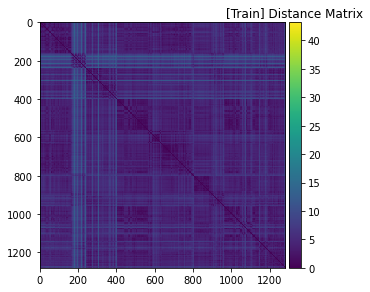

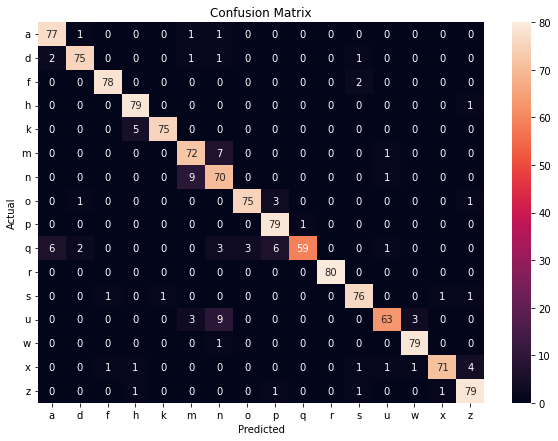

Train Accuracy = 0.9266198282591726
Feature shape: (1281, 16), Output label shape: (1281,)


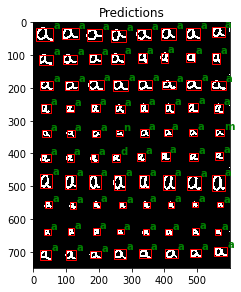

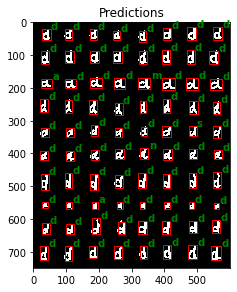

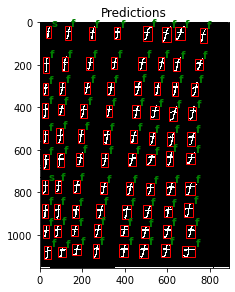

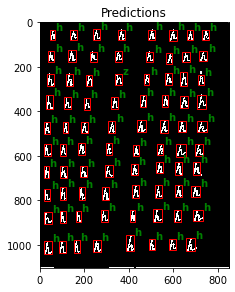

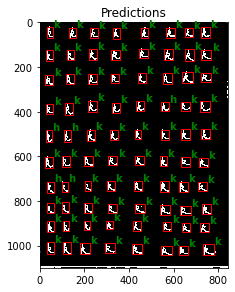

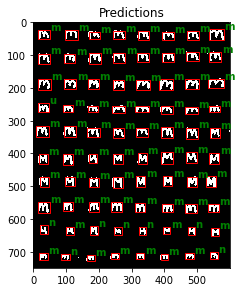

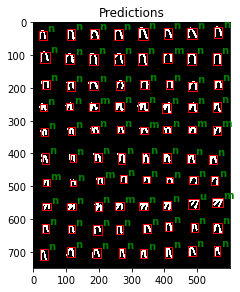

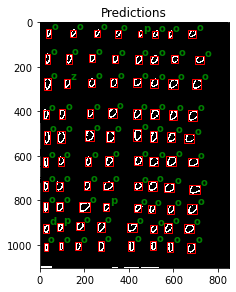

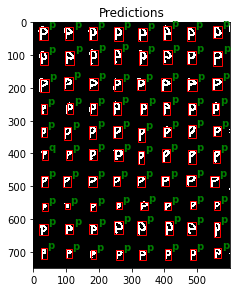

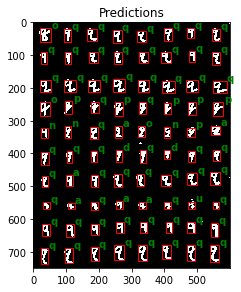

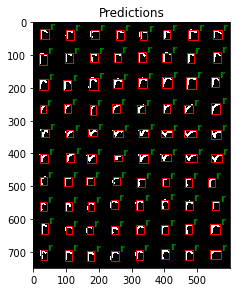

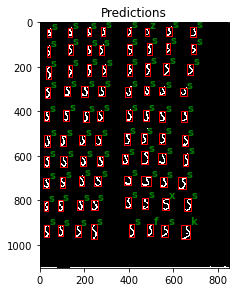

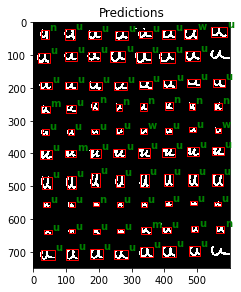

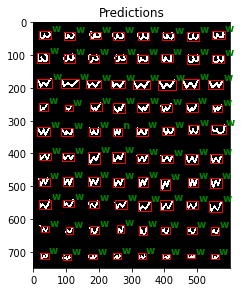

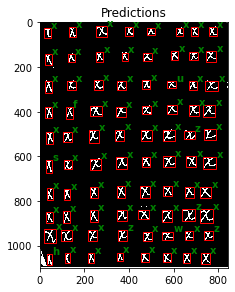

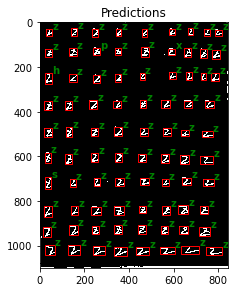

In [9]:
# Start Training
'''
img_folder: folder where all image files are located
            In this case, file hierarchy is such that OCRRecognition.ipynb file is one folder up from all the images file
            /Assignment1/OCRRecognition.ipynb
            /Assignment1/H1-16images/<all '.bmp' files>
cwd:        current working directory
path:       absolute path where images are located
dir_list:   list of all training images files to be processed
Features:   Feature list of all training image components, dimension = no. of components X no. of features
f_locs:     Store roi [minr, minc, maxr, maxc] of each image component
train_comp: List to store number of components per test image file
y:          True output class of training components
y_pred:     predicted class of training components
labs:       unique class and labels 
            {0: 'a', 1: 'd', 2: 'f', 3: 'h', 4: 'k', 5: 'm', 6: 'n', 7: 'o', 
            8: 'p', 8: 'q', 10: 'r', 11: 's', 12: 'u', 13: 'w', 14: 'x', 15: 'z'}
mean, sd:   mean and standard deviation of Training Feature list
'''

img_folder = 'H1-16images'
cwd = os.getcwd()
path = cwd + '/' + img_folder
dir_list = [ i for i in os.listdir(path) if 'test' not in i ]
Features, f_locs, y, y_pred, train_comp, labs, mean, sd = train(dir_list, path, False)
print("Feature shape: {}, Output label shape: {}".format(Features.shape, y.shape))

displayprediction(dir_list, path, f_locs, y_pred, train_comp, labs, 'Train')

*****************************
test1.bmp
Input Image Dimesnion: (750, 525)


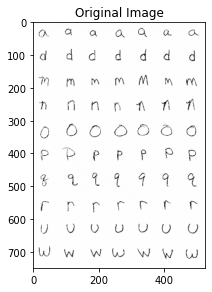

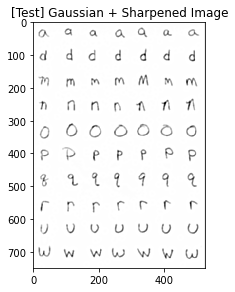

Threshold: 0.916015625


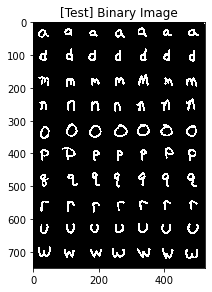

Components Labelled: 71


/Users/prashantkanth/miniforge3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


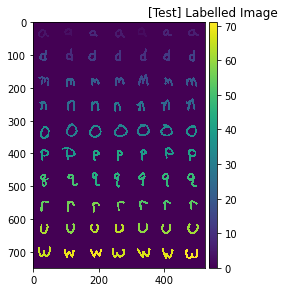

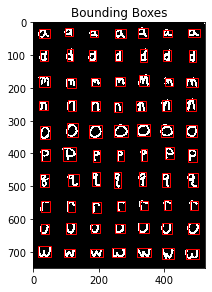

Components selected for processing: 70
*****************************
test2.bmp
Input Image Dimesnion: (1104, 850)


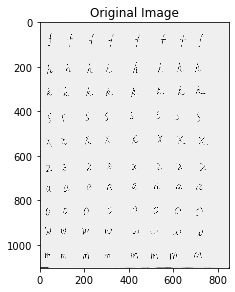

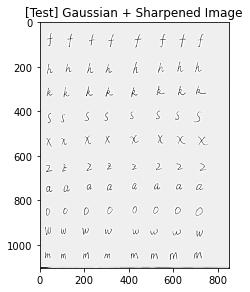

Threshold: 0.912109375


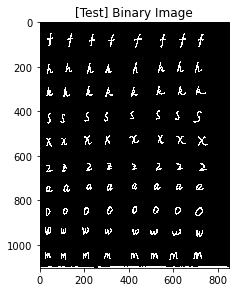

Components Labelled: 85


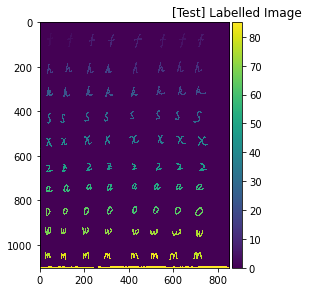

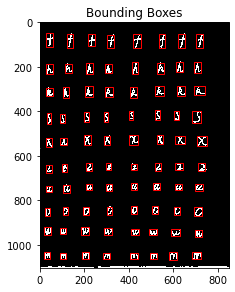

Components selected for processing: 80
Test data shape: (150,16)
Dimension of distance matrix: (150, 1281)


/Users/prashantkanth/miniforge3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


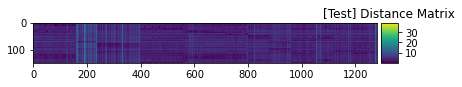


Test Accuracy = 0.8333333333333334


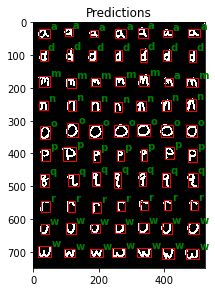

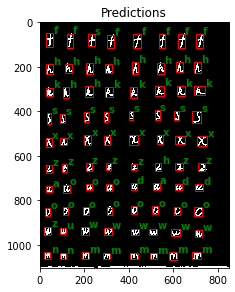

In [10]:
# Testing
'''
test_dir:       list of all test images files to be processed
ytest_pred:     Store predicted test labels
ytest_truth:    Store true labels of each components
disp:           if True, show image plots
                if False, do not show image plots
classes:        Store true classes from pickle file
locations:      Store centre coordinates of image components from pickle file
X_test:         Feature list of all test image components
X_test_locs:    Store roi [minr, minc, maxr, maxc] of each image component
X_test_comps:   List to store number of components per test image file
path:           absolute path where test image is located 
test_mode:      'default', groundtruth is taken from pickle files only when test_mode is default
                'new'; if 'new' please specify filename in test_dir list, path of the test image and any pickle file to load, if no pickle file leave it commented
                Example:
                test_dir = ['51709.bmp']
                path = '/Users/prashantkanth/Desktop/Masters/Semester II/CS534_CompVis/Assignment 1/Assignment1materials'
'''

## test_mode = 'new'
## test_dir = ['94483.jpg']
## path = <Image folder path>
## pkl = <pickle file path>

test_mode = 'default'
# test image list
test_dir = [ i for i in os.listdir(path) if 'test' in i ]

# variables to store predicted and truth values
ytest_pred = []
ytest_truth = []
score = 0
disp = True

classes = []
locations = np.empty((1,2))

X_test = np.empty((1,16))
X_test_locs = np.empty((1,4))
X_test_comps = []

# begin test process
for im in sorted(test_dir):
    test_img = path + '/' + im
    
    testimg_label, testimg_binary = processImage(test_img, '[Test]', disp)
    f, locs, comp = get_features(testimg_label, testimg_binary, disp)
    X_test = np.vstack([X_test, np.array(f)])
    X_test_locs = np.vstack([X_test_locs, np.array(locs)])
    X_test_comps.append(comp)

    if test_mode == 'default':
        pkl = cwd + '/' + im.split('.')[0] + '_gt.pkl'
        with open(pkl, 'rb') as file:
           my_dict = pickle.load(file)
           classes = classes + my_dict['classes'].tolist()
           locations = np.vstack([locations, my_dict['locations']])
    
    if test_mode == 'new' and os.path.exists(pkl):
        with open(pkl, 'rb') as file:
           my_dict = pickle.load(file)
           classes = classes + my_dict['classes'].tolist()
           locations = np.vstack([locations, my_dict['locations']])

X_test = X_test[1:, :]
X_test_locs = X_test_locs[1:, :]
locations = locations[1:, :]

print("Test data shape: ({},{})".format(len(X_test), len(X_test[0])))

# normalise test data
X_test = (X_test - mean) / sd

# Recognition of Test Images
D_test = cdist(X_test, Features)
print("Dimension of distance matrix: {}".format(D_test.shape))
display(D_test, '[Test] Distance Matrix')
D_test_idx = np.argsort(D_test, axis=1)
for i in range(D_test.shape[0]):
    n_neighbors = [y[val] for val in D_test_idx[i, 0:5]]
    ytest_pred.append(labs.get(mode(n_neighbors)[0][0]))
    ## ytest_pred.append( labs.get( y[ np.argmin( D_test[i, :] ) ] ) )

# Ground Truth
if test_mode == 'default' or (test_mode == 'new' and os.path.exists(pkl)):
    for i in range(len(ytest_pred)):
        verts = [[X_test_locs[i][1], X_test_locs[i][2]], [X_test_locs[i][3], X_test_locs[i][2]], [X_test_locs[i][3], X_test_locs[i][0]], [X_test_locs[i][1], X_test_locs[i][0]]]
        t_val = points_in_poly(locations, verts)
        ytest_truth.append(classes[np.where(t_val == True)[0][0]])
    # for i in range(len(ytest_pred)):
    #     print("predicted: {}. ground truth: {}".format(ytest_pred[i], ytest_truth[i]))

    # Accuracy or Recognition Rate Calculation    
    for i in range(len(ytest_pred)):
        if ytest_pred[i] == ytest_truth[i]:
            score += 1
    print("\nTest Accuracy = {}".format(score/len(ytest_pred)))

displayprediction(test_dir, path, X_test_locs, ytest_pred, X_test_comps, labs)